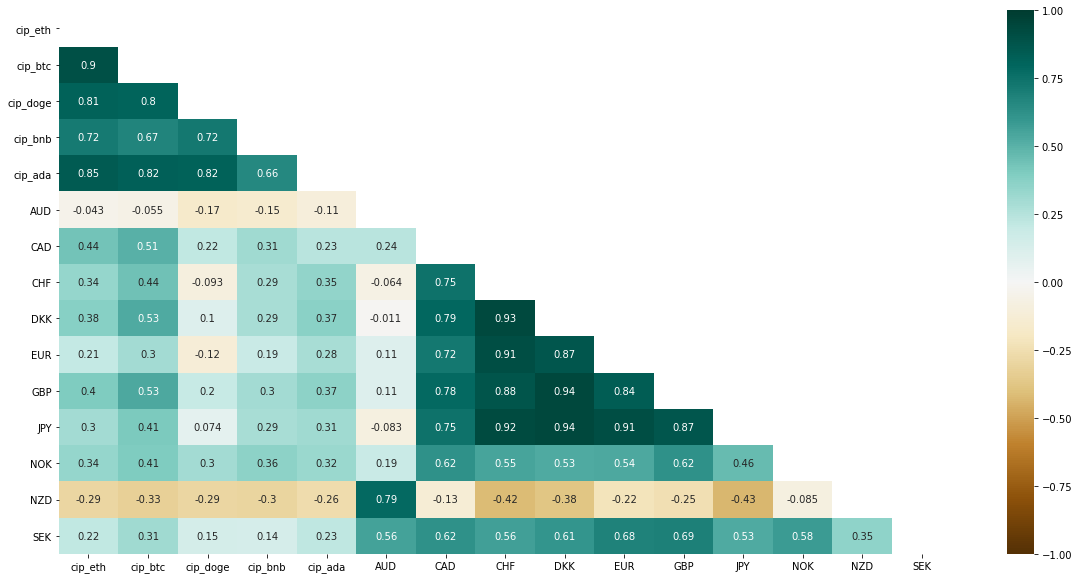

In [290]:
####################################################################
# Correlation between crypto CIP and currency CIP
####################################################################

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy.stats.mstats import winsorize
from random import seed
from random import random
import seaborn as sns
from IPython.display import display
pd.options.mode.chained_assignment = None
import warnings
import datetime
import calendar
warnings.filterwarnings("ignore")
np.random.seed(11111)

df = pd.read_pickle('data/cip_dataset.pkl')

def load_data(load):
    spot = pd.read_csv(f'data/spot_{load}_usdt_1h.csv', parse_dates=['timestamp'])
    perp = pd.read_csv(f'data/perp_{load}_usdt_1h.csv', parse_dates=['timestamp'])
    perp.sort_values(by = 'epoch', ascending=True, inplace=True)
    spot.sort_values(by = 'epoch', ascending=True, inplace=True)
    perp = perp.reset_index(drop=True)
    spot = spot.reset_index(drop=True)
    funding_rate = pd.read_csv(f'data/rate_{load}_usdt.csv', parse_dates=['timestamp'])
    return spot, perp, funding_rate

def create_panel(spot, perp, funding_rate):
    panel = perp[['epoch', 'timestamp', 'close', 'usd_volume']]
    panel['day'] = panel['timestamp'].dt.round('D')
    panel = panel.rename(columns={'close': 'perp', 'usd_volume': 'perp_usd_volume'})
    panel = pd.merge(panel, spot[['epoch', 'close', 'usd_volume']], on='epoch', how='left')
    panel = panel.rename(columns={'close': 'spot', 'usd_volume': 'spot_usd_volume'})
    panel = pd.merge(panel, funding_rate[['epoch', 'funding_rate']], on='epoch', how='left')
    panel.sort_values(by = 'epoch', ascending=True, inplace=True)
    panel = panel.reset_index(drop=True)
    return panel

currencies = ['eth', 'btc', 'doge', 'bnb', 'ada']
panel_all = []
threshold = 0.45
wins = True
for i in range (0,len(currencies)):
    spot, perp, funding_rate = load_data(currencies[i])
    panel_temp = create_panel(spot, perp, funding_rate)
    panel_all.append(panel_temp)
for i in range (0,len(currencies)):
    T = 1/(3*365)
    panel_all[i]['cip'] = (1/T)*(np.log(panel_all[i]['perp']) - np.log(panel_all[i]['spot'])) 
    if wins:
        panel_all[i]['cip'] = winsorize(panel_all[i]['cip'], limits = (0.025, 0.025))
    mean = np.round(panel_all[i]['cip'].mean(),4)
    days = (panel_all[i]['day'].iloc[-1] - panel_all[i]['day'].iloc[0]).days

df_corr = pd.DataFrame()
for i, curr in enumerate(currencies):
    if i == 0:
        df_corr = panel_all[i][['epoch', 'cip', 'funding_rate']]
        df_corr.columns = ['epoch', 'cip_' + curr, 'funding_rate_' + curr]
        s = panel_all[i]
        df_corr['ret_' + curr] = (s['spot'] - s['spot'].shift(1)) / s['spot'].shift(1)
    else:
        s = panel_all[i]
        s['ret'] = (s['spot'] - s['spot'].shift(1)) / s['spot'].shift(1)
        df_corr = pd.merge(df_corr, s[['epoch', 'cip', 'funding_rate', 'ret']], on = 'epoch', how = 'left')
        df_corr = df_corr.rename(columns = {'cip' : 'cip_' + curr, 'funding_rate': 'funding_rate_' + curr, 'ret': 'ret_' + curr})

df_corr['g'] = (df_corr['epoch']-1)//(3600 * 8 * 3)
df_corr2 = df_corr.groupby(['g']).mean().drop(columns = ['epoch'])
df_corr2 = df_corr2[['cip_eth', 'cip_btc', 'cip_doge', 'cip_bnb', 'cip_ada']]
df_corr2 = df_corr2.reset_index()

df = df[df['tenor'] == '3m']
df = df[df['group'] == 'g10'].reset_index(drop = True)

df['epoch'] = df['date'].apply(lambda x: calendar.timegm(x.timetuple()))
df['epoch'] = df['epoch'] + 3600 * 24
df['g'] = (df['epoch'] - 1) // (3600 * 8 * 3)
df = df.sort_values(by = 'g').reset_index(drop = True)

df['cip_govt'] = -df['cip_govt']
df_cip = pd.pivot_table(df, values = 'cip_govt', index = 'g', columns = 'currency').reset_index()

df_corr2 = pd.merge(df_corr2, df_cip, how = 'left', on = 'g')
df_corr2 = df_corr2.set_index('g')

plt.figure(figsize=(20, 10))
mask = np.triu(np.ones_like(df_corr2.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_corr2.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

Crypto PC1 variance explained:  0.951
Currency PC1 variance explained:  0.686


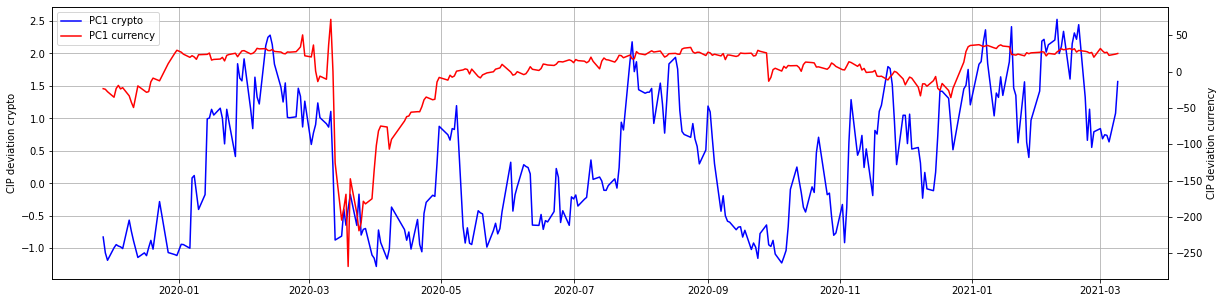

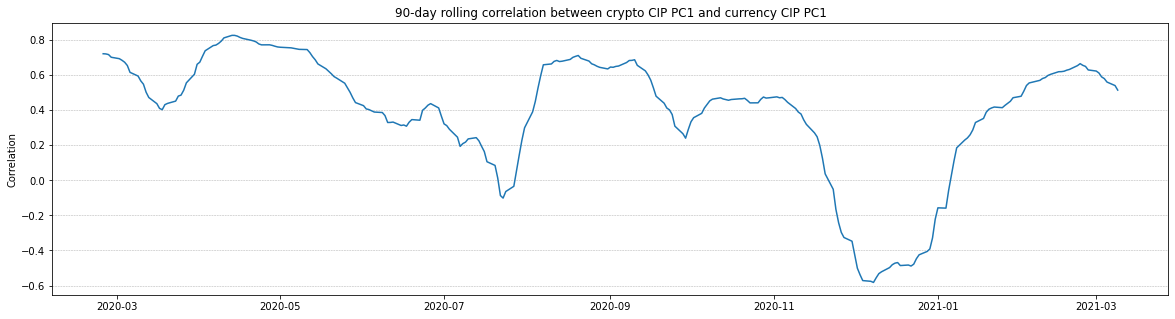

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PC1_crypto   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     74.30
Date:                Mon, 12 Sep 2022   Prob (F-statistic):           3.21e-16
Time:                        12:40:52   Log-Likelihood:                -425.38
No. Observations:                 320   AIC:                             854.8
Df Residuals:                     318   BIC:                             862.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3584      0.051      6.990      0.000       0.258       0.459
PC1_currency     0.0096      0.001      8.620      0.000       0.007       0.012
==============================================================================
Omnibus:                       65.509   Durbin-Watson:                   0.221
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.966
Skew:                           0.052   Prob(JB):                     0.000927
Kurtosis:                       1.982   Cond. No.                         46.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [291]:
####################################################################
# PC of CIP deviation and rolling correlation
####################################################################

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import statsmodels.api as sm

# crypto_ls = ['cip_eth', 'cip_btc', 'cip_doge', 'cip_bnb', 'cip_ada']
crypto_ls = ['cip_eth', 'cip_btc']
currency_ls = ['AUD', 'CAD', 'CHF', 'DKK', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK']

X_crypto = df_corr2[crypto_ls].dropna().values
pca = PCA()
X_crypto_pc = pca.fit_transform(X_crypto)
print('Crypto PC1 variance explained: ', round(pca.explained_variance_ratio_[0], 3))

X_currency = df_corr2[currency_ls].dropna(subset = currency_ls).values
pca = PCA()
X_currency_pc = pca.fit_transform(X_currency)
X_currency_pc = -X_currency_pc
print('Currency PC1 variance explained: ', round(pca.explained_variance_ratio_[0], 3))

df_pc = df_corr2.copy()
df_pc['PC1_crypto'] = np.nan
df_pc['PC1_currency'] = np.nan

df_pc.loc[df_pc[crypto_ls].notnull().prod(axis = 1).astype(bool), 'PC1_crypto'] = X_crypto_pc[:, 0]
df_pc.loc[df_pc[currency_ls].notnull().prod(axis = 1).astype(bool), 'PC1_currency'] = X_currency_pc[:, 0]

df_pc2 = df_pc[['PC1_crypto', 'PC1_currency']]

min_obs = 50
NT = 90
T = len(df_pc2)
corr_arr = np.zeros(T - NT)

def cal_corr(x):
    if len(x.dropna(subset = ['PC1_crypto', 'PC1_currency'])) < min_obs:
        return np.nan
    else:
        return x.corr().values[0][1]

df_pc_rolling = pd.DataFrame()
for t in range(T - NT):
    df_ = df_pc2.iloc[t: t + NT, :]
    corr_arr[t] = cal_corr(df_)
df_pc_rolling['corr'] = corr_arr
df_pc_rolling['g'] = df_pc2.index[NT:]

g_date = df[['g', 'date']].drop_duplicates().reset_index(drop = True)
df_pc_rolling = pd.merge(df_pc_rolling, g_date, on = ['g'])

df_pc2 = df_pc2.reset_index()
df_pc2 = pd.merge(df_pc2, g_date, on = ['g'])
df_pc2 = df_pc2.dropna()

fig, ax = plt.subplots(figsize =(20,5))
lns1 = ax.plot(df_pc2['date'], df_pc2['PC1_crypto'], color = 'b', label = 'PC1 crypto')
plt.ylabel('CIP deviation crypto')
ax2 = ax.twinx()
lns2 = ax2.plot(df_pc2['date'], df_pc2['PC1_currency'], color = 'r', label = 'PC1 currency')
plt.ylabel('CIP deviation currency')
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc = 0)
ax.grid()
plt.show()

fig, ax = plt.subplots(figsize =(20,5))
plt.plot(df_pc_rolling['date'], df_pc_rolling['corr'])
ax.grid(axis='y', linestyle='--', linewidth=.5)
plt.ylabel('Correlation')
plt.title(f'{NT}-day rolling correlation between crypto CIP PC1 and currency CIP PC1')
plt.show()

df_pc2 = df_pc2.dropna()
Y = df_pc2['PC1_crypto']
X = sm.add_constant(df_pc2['PC1_currency'])

model = sm.OLS(Y, X)
results = model.fit()
display(results.summary())